<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-MLD-climatology" data-toc-modified-id="Make-MLD-climatology-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make MLD climatology</a></span></li></ul></div>

# MLD additional info about Argo Obs

Source: MLD_evaluation_MdP_16Oct19.ipynb

In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
import bp12_tools as bp12
import bp12_tools.plot_utils as pu

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

---

# MLD Data Stats

Load monthly Argo profile and model data co-located on 1 degree grid

In [2]:
ds_mld= xr.open_dataset(f'../data/MLD/BP12_OBS_monthly_mld.nc')
latidx_of_data1 = np.min(np.where(~np.isnan(np.nanmean(ds_mld.mld_mdl[0,:,:].values, axis=1))))
latidx_of_data2 = np.max(np.where(~np.isnan(np.nanmean(ds_mld.mld_mdl[0,:,:].values, axis=1))))
ds_mld = ds_mld.isel(lat=slice(latidx_of_data1, latidx_of_data2))

In [3]:
mld_obs_clim, mld_mdl_clim = [], []

for i in range(1, 13, 1):     
    x = ds_mld.sel(time=ds_mld['time.month']==i)
    mld_obs_clim += np.nanmean(x.mld_obs, axis=0),
    mld_mdl_clim += np.nanmean(x.mld_mdl_subsampled, axis=0),
    
mld_obs_clim = np.array(mld_obs_clim)
mld_mdl_clim = np.array(mld_mdl_clim)

Load number of observations of Argo profile

In [4]:
num_obs = xr.open_dataset(f'../data/MLD/Argo_obs_monthly_1deg_02_09_counts.nc')
num_obs_clim = num_obs.num_obs.groupby('time.month').sum()
num_obs_2002 = [int(num_obs.num_obs.sel(time=f'2002-{mo:02d}-15').values) for mo in range(1,12+1)]  
num_obs_2009 = [int(num_obs.num_obs.sel(time=f'2009-{mo:02d}-15').values) for mo in range(1,12+1)] 

Count ocean points based on model

In [5]:
oceanpts = ds_mld.mld_mdl[0].where(ds_mld.mld_mdl[0]<5)
tot_gridpts = ds_mld.lat.size * ds_mld.lon.size
tot_ocegridpts = np.count_nonzero(np.isnan(oceanpts.to_masked_array()))
print(f"total number of gridpoints {tot_gridpts}")
print(f"ocean gridpoints {tot_ocegridpts}")
print(f"percentage of grid that is ocean {100*(tot_ocegridpts/tot_gridpts):.02f} %")

total number of gridpoints 16967
ocean gridpoints 14266
percentage of grid that is ocean 84.08 %


Sum number of observations over time period, and for start of dataset, and end of model period

In [6]:
ngrdpts = xr.Dataset(
    {
        'num_gpts': (('time',), 
                    [np.sum(~np.isnan(ds_mld.mld_obs[i])) for i in range(ds_mld.time.size)]),
    },
    {"time": num_obs.time.values},
)
num_gpts_clim = ngrdpts.groupby('time.month').sum()
num_gpts_2002 = ngrdpts.sel(time=slice('2002-01-01','2002-12-31'))
num_gpts_2009 = ngrdpts.sel(time=slice('2009-01-01','2009-12-31'))

Convert into percentage

In [7]:
ngrdpts_pers_month = [100*((np.sum(~np.isnan(mld_obs_clim[i])))/tot_ocegridpts) for i in range(12)]
pers_gpts_2002 = [100*(ngrdpts.num_gpts.sel(time=f'2002-{mo:02d}-15').values/tot_ocegridpts) for mo in range(1,12+1)]  
pers_gpts_2009 = [100*(ngrdpts.num_gpts.sel(time=f'2009-{mo:02d}-15').values/tot_ocegridpts) for mo in range(1,12+1)]  

### Make MLD climatology

In [8]:
mld_obs_clim = []
mld_mdl_clim = []

for i in range(1, 13, 1):
        
    x = ds_mld.sel(time=ds_mld['time.month']==i)
    mld_obs_clim += np.nanmean(x.mld_obs, axis=0),
    mld_mdl_clim += np.nanmean(x.mld_mdl_subsampled, axis=0),
    
mld_obs_clim = np.array(mld_obs_clim)
mld_mdl_clim = np.array(mld_mdl_clim)

# PLOT

In [9]:
red  = pu.formatting.get_rbg_colors('r')
blue = pu.formatting.get_rbg_colors('b')

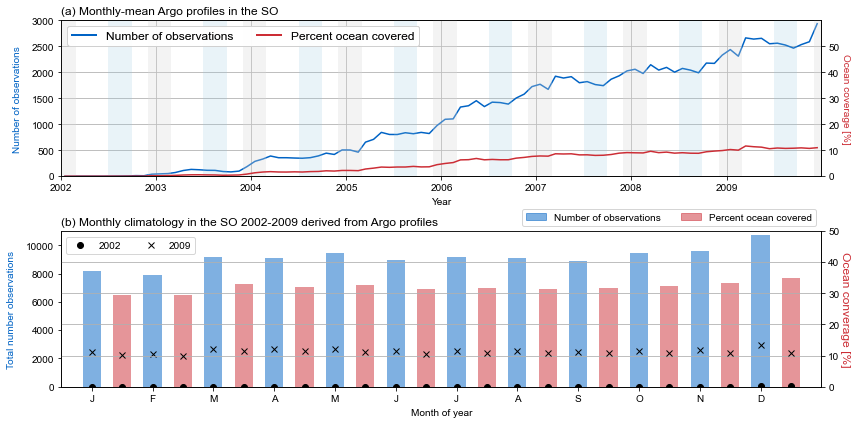

In [10]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(211)

ax.plot(num_obs.time, num_obs.num_obs, color=blue)
ax.set_ylim(0, 3000)
ax.yaxis.set_ticks(np.arange(0, 3500, 500))
ax.set_xlabel("Year", labelpad=5)
ax.set_ylabel("Number of observations", labelpad=10, color=blue)
ax.grid()

ax2= ax.twinx()
ax2.plot(ngrdpts.time, 100*(ngrdpts.num_gpts/tot_ocegridpts), color=red)
ax2.set_ylim(0, 60)
ax2.yaxis.set_ticks(np.arange(0, 60, 10))
ax2.set_ylabel("Ocean coverage [%]", labelpad=10, rotation=-90, color=red)
pu.timeseries.add_seas(ax2, (0,3000))
line_r = mpl.lines.Line2D([], [], color=blue, lw=2, label='Number of observations')
line_b = mpl.lines.Line2D([], [], color=red, lw=2, label="Percent ocean covered")
leg1 = ax2.legend(handles = [line_r, line_b], ncol=2, fontsize=12, 
                  bbox_to_anchor=(0, 0.8, 1, 0.4), loc="lower left")
ax2.add_artist(leg1)
ax.set_xlim([pd.Timestamp(2002,1,1), pd.Timestamp(2009,12,31)])
ax.set_title('(a) Monthly-mean Argo profiles in the SO', loc='left')


ax3 = fig.add_subplot(212)
barwidth = [0.3 for i in range(12)]
b1=ax3.bar(range(12), num_obs_clim.values, width=barwidth, alpha=0.5, color=blue)
ax3.plot(range(12), num_obs_2002, 'o', color='k')
ax3.plot(range(12), num_obs_2009, 'x', color='k')
ax3.set_ylim(0, 11000)
ax3.yaxis.set_ticks(np.arange(0, 12000, 2000))
ax3.set_xlabel("Month of year", labelpad=5)
ax3.set_ylabel("Total number observations", labelpad=10, color=blue)

ax4= ax3.twinx()
b2=ax4.bar(np.arange(0.5,12.5,1), ngrdpts_pers_month, width=barwidth, alpha=0.5, color=red)
ax4.plot(np.arange(0.5, 12.5, 1), pers_gpts_2002, 'o', color='k')
ax4.plot(np.arange(0.5, 12.5, 1), pers_gpts_2009, 'x', color='k')
ax4.xaxis.set_ticks([])
ax4.set_ylim(0, 50)
ax4.set_ylabel("Ocean converage [%]", labelpad=10, rotation=-90,  color=red, fontsize=12)

ax4.grid()
ax4.xaxis.set_ticks([])
ax4.set_xlim(-0.5, 12)
month_ticks = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
ax4.xaxis.set_ticks(np.arange(12))
ax4.xaxis.set_ticklabels(month_ticks)

handles = [mpl.patches.Patch(color=blue, alpha=0.5), mpl.patches.Patch(color=red, alpha=0.5)]
leg1 = ax4.legend(handles,['Number of observations','Percent ocean covered'],
                 bbox_to_anchor=(0.6, 1, 1, 0.4), loc="lower left", ncol=2)
ax4.add_artist(leg1)

handles = [mpl.lines.Line2D([], [], marker=marker, mec='k', mfc='k', ls='') for marker in ['o', 'x']]
ax4.legend(handles, ['2002', '2009'], bbox_to_anchor=(0, 0.82, 1, 0.4), loc="lower left", ncol=2)
ax4.set_title('(b) Monthly climatology in the SO 2002-2009 derived from Argo profiles', loc='left')
plt.tight_layout()

plt.savefig(f'../figures/S05.png', bbox_inches='tight', dpi=300)